In [ ]:
# Import all the necessary libraries
from textblob import TextBlob

# Utilities
import re
import pickle
import numpy as np
import pandas as pd

# Plot libraries
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from cleantext import clean
import contractions
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
#Import the twitter dataset and convert it to dataframe
twitterDataFrame = pd.read_csv('/content/sample_data/NewTwitterDataset.csv')

In [ ]:
# Check the dimensions of dataset
twitterDataFrame.shape

(100000, 7)

In [ ]:
# View the first 5 rows of data
twitterDataFrame.head(20)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,161253,True,Wed Oct 04 13:59:33 +0000 2017,@161252 What's that egg website people talk about,192623,192625.0
1,2,296574,True,Fri Oct 06 18:29:06 +0000 2017,Why!🤷🏻‍♀️ #iOS11 @AppleSupport https://t.co/BX...,738237,NaN
2,3,AppleSupport,False,Tue Nov 14 17:38:01 +0000 2017,@693975 We can assist you. We recommend updati...,2414303,2414304.0
3,4,539096,True,Thu Oct 12 06:04:41 +0000 2017,@331912 @115955 Thats better than having an un...,1793928,1793930.0
4,5,617376,True,Mon Nov 06 20:30:49 +0000 2017,@VirginAmerica is probably one of the best air...,2088017,NaN
5,6,577298,True,Sun Oct 29 23:13:33 +0000 2017,@AlaskaAir Phone system seems to be down,1941219,1941216.0
6,7,SpotifyCares,False,Tue Nov 21 05:56:34 +0000 2017,@325106 Cool! Can you DM us a screenshot of yo...,NaN,863669.0
7,8,645101,True,Fri Nov 10 00:12:30 +0000 2017,@Uber_Support Reports are there are 68 Ubers w...,2206335,2206332.0
8,9,AppleSupport,False,Wed Oct 18 12:33:00 +0000 2017,@565060 Since our Twitter support is available...,NaN,1895824.0
9,10,162033,True,Mon Nov 20 19:15:58 +0000 2017,@AmazonHelp Saw that but only after a labored ...,NaN,2744169.0


In [ ]:
# Get the information of dataset
twitterDataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   tweet_id                 100000 non-null  int64  
 1   author_id                100000 non-null  object 
 2   inbound                  100000 non-null  bool   
 3   created_at               100000 non-null  object 
 4   text                     100000 non-null  object 
 5   response_tweet_id        63165 non-null   object 
 6   in_response_to_tweet_id  71597 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 4.7+ MB


In [ ]:
# Check if there are null values
twitterDataFrame['text'].isnull().any()

False

In [ ]:
nltk.download('stopwords')
# Function to clean the dataset using regular expression
def clean_tweet(tweet):
    '''
    Function to clean the tweets by removal of  links, special characters,
    and stopwords using regular expressions and NLTK.
    '''
    # remove URLs, RTs, and mentions
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r'RT[\s]+', '', tweet)
    tweet = re.sub(r'@[A-Za-z0-9_]+', '', tweet)

    # remove non-alphanumeric characters
    tweet = re.sub(r'\W+', ' ', tweet)

    # remove stopwords
    stop_words = set(stopwords.words('english'))
    additional_stopwords = {
        'rt', 'amp', 'via', 'ht', '...', '@username', 'http', 'https', 'www',
        'lol', 'omg', 'wtf', 'imho', 'fyi', 'tl', 'dr', 'bff', 'dm', 'mt', 'ht',
        'ff', 'ftw', 'brb', 'tbh', 'irl', 'jk', 'nvm', 'smh', 'tbh', 'tk', 'ymmv',
        'yolo', 'rofl', 'lmao', 'smh', 'af', 'fomo', 'hmu', 'icymi', 'imo', 'ily',
        'mfw', 'mrw', 'nsfw', 'omw', 'tfw', 'tbt', 'tmi', 'ttys', 'ykwim', 'yw',
        'irl', 'rtfm', 'gbtw', 'ygm', 'yolo', 'yoyow', 'ywia', 'ywsyl', 'ywsyyg'
    }
    stop_words |= additional_stopwords
    words = nltk.word_tokenize(tweet)
    words = [word.lower() for word in words if word.lower() not in stop_words]

    # join the words back into a string
    cleaned_tweet = ' '.join(words)

    return cleaned_tweet


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
nltk.download('punkt')
twitterDataFrame['clean_tweet'] = twitterDataFrame['text'].apply(clean_tweet)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
twitterDataFrame['clean_tweet'].head(20)

0                               egg website people talk
1                                                 ios11
2     assist recommend updating ios 11 1 1 chance al...
3     thats better unstable connection drops every 5...
4           probably one best airlines ever experienced
5                                    phone system seems
6                  cool us screenshot bank statement rb
7     reports 68 ubers waiting passengers something ...
8     since twitter support available english get he...
9     saw labored hunt bigger point though usb 2 0 e...
10    hi please call 844 401 8500 option 2 file clai...
11     apologize inconvenience kindly send note connect
12    ok check thanks also kudos flight safety video...
13                     please us details happened today
14    give contact number cloudtail india pvt ltd ta...
15                          pretty bad least queso good
16          buffering getting worse second going amazon
17    also guactober sounds like good time make 

In [ ]:
preProcessedData = twitterDataFrame[['tweet_id', 'clean_tweet']]

In [ ]:
preProcessedData.head(20)

,tweet_id,clean_tweet
0,1,egg website people talk
1,2,ios11
2,3,assist recommend updating ios 11 1 1 chance al...
3,4,thats better unstable connection drops every 5...
4,5,probably one best airlines ever experienced
5,6,phone system seems
6,7,cool us screenshot bank statement rb
7,8,reports 68 ubers waiting passengers something ...
8,9,since twitter support available english get he...
9,10,saw labored hunt bigger point though usb 2 0 e...


In [ ]:
preProcessedData['clean_tweet'].isnull().any()

False

### Reference

### https://towardsdatascience.com/cleaning-preprocessing-text-data-for-sentiment-analysis-382a41f150d6

## For Review 3

In [ ]:
preProcessedData.head()

,tweet_id,clean_tweet
0,1,egg website people talk
1,2,ios11
2,3,assist recommend updating ios 11 1 1 chance al...
3,4,thats better unstable connection drops every 5...
4,5,probably one best airlines ever experienced


In [ ]:
# Check Sentiment
# Function to check sentiment of tweets using TextBlob
def sentimentCheck(tweet):
    text = TextBlob(tweet)
    sentiment = text.sentiment.polarity
    if sentiment > 0:
        return 'positive'
    elif sentiment < 0:
        return 'negative'
    else:
        return 'neutral'


In [ ]:
# Add sentiment
preProcessedData['sentiment'] = preProcessedData['clean_tweet'].apply(sentimentCheck)

<ipython-input-22-5eacc137a50a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preProcessedData['sentiment'] = preProcessedData['clean_tweet'].apply(sentimentCheck)


In [ ]:
preProcessedData.head()

,tweet_id,clean_tweet,sentiment
0,1,egg website people talk,neutral
1,2,ios11,neutral
2,3,assist recommend updating ios 11 1 1 chance al...,neutral
3,4,thats better unstable connection drops every 5...,positive
4,5,probably one best airlines ever experienced,positive


In [ ]:
# get count of different sentiments
preProcessedData['sentiment'].value_counts()

neutral     43453
positive    36437
negative    20110
Name: sentiment, dtype: int64

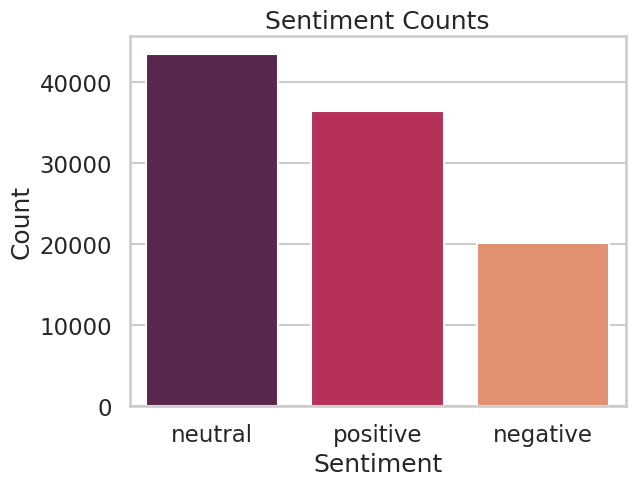

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the counts of each sentiment category
counts = preProcessedData['sentiment'].value_counts()

# Set the style and context of the plot
sns.set(style="whitegrid")
sns.set_context("talk")

# Create the bar chart
ax = sns.barplot(x=counts.index, y=counts.values, palette="rocket")

# Add labels to the chart
ax.set_title("Sentiment Counts")
ax.set_xlabel("Sentiment")
ax.set_ylabel("Count")

# Show the chart
plt.show()


In [ ]:
preProcessedData.loc[preProcessedData['sentiment'] == "negative", 'sentiment'] = 0
preProcessedData.loc[preProcessedData['sentiment'] == "positive", 'sentiment'] = 1
preProcessedData.loc[preProcessedData['sentiment'] == "neutral", 'sentiment'] = 2

In [ ]:
negative_sentiment = preProcessedData[preProcessedData['sentiment'] == 0]
positive_sentiment = preProcessedData[preProcessedData['sentiment'] == 1]
neutral_sentiment = preProcessedData[preProcessedData['sentiment'] == 2]

In [ ]:
positive_sentiment = positive_sentiment.iloc[:int(8000)]
negative_sentiment = negative_sentiment.iloc[:int(8000)]
neutral_sentiment = neutral_sentiment.iloc[:int(8000)]

In [ ]:
dataset = pd.concat([negative_sentiment, positive_sentiment, neutral_sentiment])

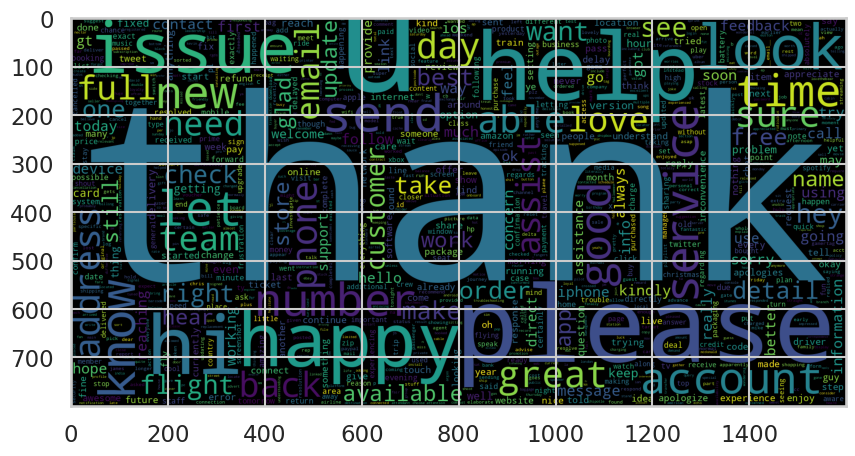

In [ ]:
plt.figure(figsize = (10,8))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(positive_sentiment['clean_tweet']))
plt.imshow(wc)

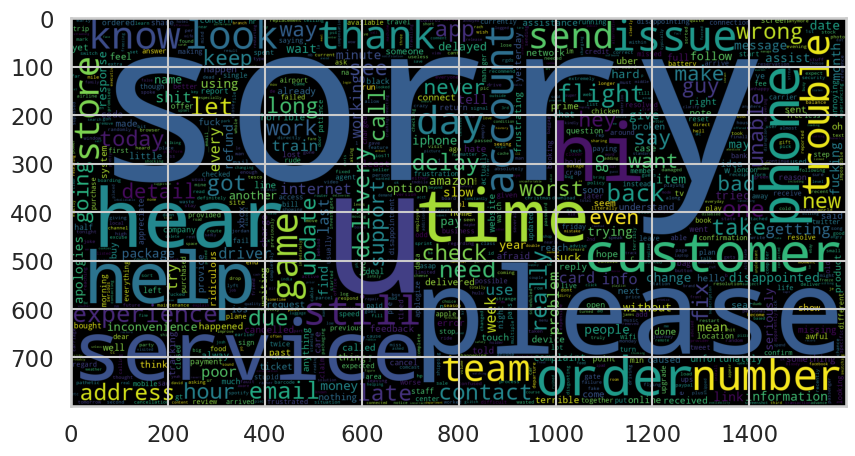

In [ ]:
plt.figure(figsize = (10,8))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(negative_sentiment['clean_tweet']))
plt.imshow(wc)

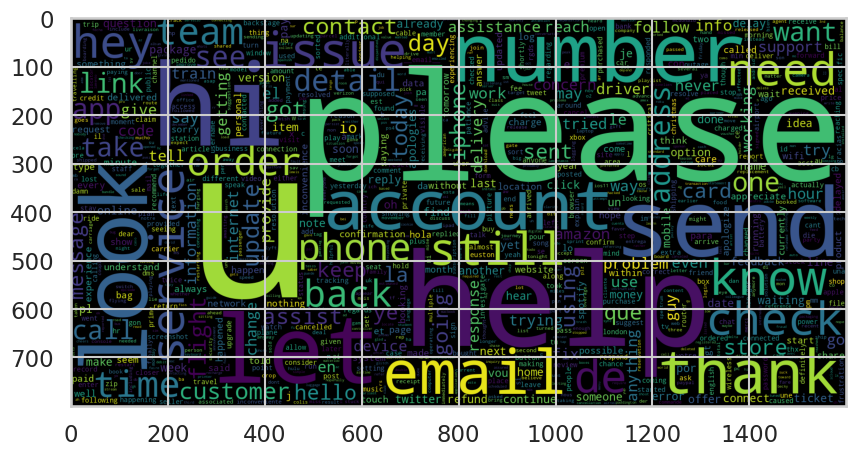

In [ ]:
plt.figure(figsize = (10,8))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(neutral_sentiment['clean_tweet']))
plt.imshow(wc)

In [ ]:
dataset.to_csv('/content/sample_data/preprocessedData.csv', index=False)


In [ ]:
shuffled_df = dataset.sample(frac=1.0, random_state=42)

# Save the shuffled DataFrame as a CSV
shuffled_df.to_csv('/content/sample_data/preprocessedData1.csv', index=False)

In [ ]:
dataset = pd.read_csv("/content/sample_data/preprocessedData1.csv")

In [ ]:
dataset['clean_tweet'] = dataset['clean_tweet'].astype(str)
dataset['clean_tweet'].fillna(value='', inplace=True)

dataset['clean_tweet'] = dataset['clean_tweet'].apply(lambda x: str(x) if isinstance(x, (str, float)) else '')


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(dataset['clean_tweet'].values)
X = tokenizer.texts_to_sequences(dataset['clean_tweet'].values)
X = pad_sequences(X)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

embedding_dim = 128
lstm_units = 196
vocab_size = 2000

lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, embedding_dim, input_length=X.shape[1]))
lstm_model.add(SpatialDropout1D(0.4))
lstm_model.add(LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(3, activation='softmax'))
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm_model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 33, 128)           256000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 33, 128)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense (Dense)               (None, 3)                 591       
                                                                 
Total params: 511,391
Trainable params: 511,391
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Making the test train split

from sklearn.model_selection import train_test_split

# Convert sentiment labels to one-hot encoded vectors
one_hot_sentiment = pd.get_dummies(dataset['sentiment']).values

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, one_hot_sentiment, test_size=0.25, random_state=42)

# Print the shapes of the training and testing sets
print("Training set shapes - X: {}, Y: {}".format(X_train.shape, Y_train.shape))
print("Testing set shapes - X: {}, Y: {}".format(X_test.shape, Y_test.shape))


Training set shapes - X: (18000, 33), Y: (18000, 3)
Testing set shapes - X: (6000, 33), Y: (6000, 3)


In [ ]:
batch_size = 32
epochs = 10

# Train the lstm_model
lstm_history = lstm_model.fit(X_train, Y_train,
                    epochs=epochs,
                    validation_data=(X_test, Y_test),
                    batch_size=batch_size)


Epoch 1/10
563/563 [==============================] - 142s 242ms/step - loss: 0.5351 - accuracy: 0.7851 - val_loss: 0.2609 - val_accuracy: 0.9242
Epoch 2/10
563/563 [==============================] - 124s 220ms/step - loss: 0.2347 - accuracy: 0.9316 - val_loss: 0.2404 - val_accuracy: 0.9332
Epoch 3/10
563/563 [==============================] - 125s 222ms/step - loss: 0.2015 - accuracy: 0.9412 - val_loss: 0.2443 - val_accuracy: 0.9330
Epoch 4/10
563/563 [==============================] - 122s 216ms/step - loss: 0.1853 - accuracy: 0.9440 - val_loss: 0.2376 - val_accuracy: 0.9370
Epoch 5/10
563/563 [==============================] - 122s 216ms/step - loss: 0.1697 - accuracy: 0.9484 - val_loss: 0.2449 - val_accuracy: 0.9363
Epoch 6/10
563/563 [==============================] - 124s 221ms/step - loss: 0.1551 - accuracy: 0.9514 - val_loss: 0.2631 - val_accuracy: 0.9297
Epoch 7/10
563/563 [==============================] - 124s 220ms/step - loss: 0.1402 - accuracy: 0.9562 - val_loss: 0.2759 -

In [ ]:
# Evaluate model
loss, accuracy = lstm_model.evaluate(X_test, Y_test, batch_size=32)
print('Loss:', loss)
print('Accuracy:', accuracy)

188/188 [==============================] - 5s 27ms/step - loss: 0.3390 - accuracy: 0.9228
Loss: 0.3389572501182556
Accuracy: 0.9228333234786987


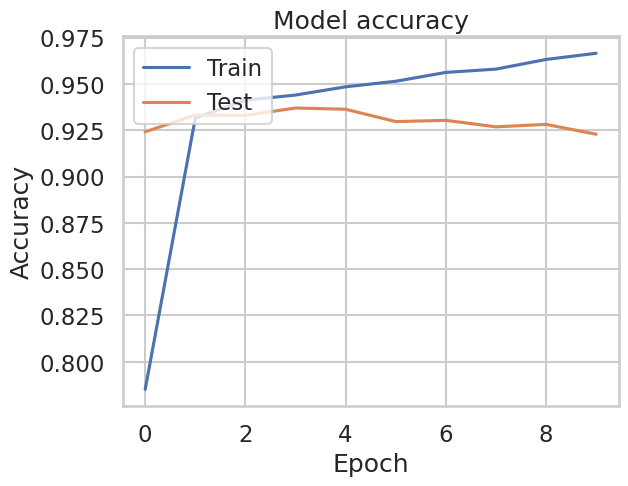

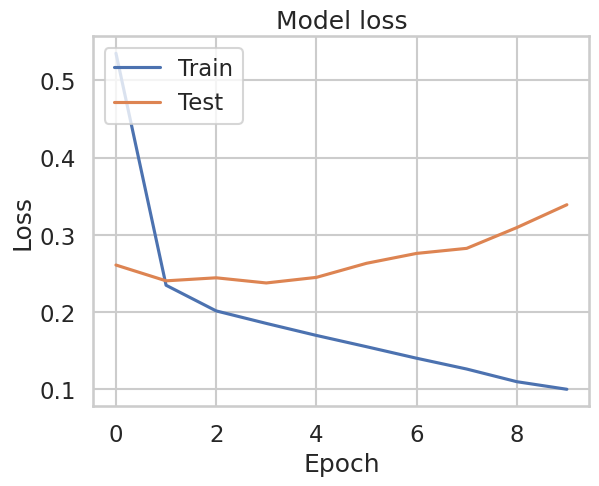

In [ ]:
# plot the graphs for accuracy
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# plot the graphs for loss
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:

from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
# Tokenize the tweets
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(dataset['clean_tweet'].values)
X = tokenizer.texts_to_sequences(dataset['clean_tweet'].values)
X = pad_sequences(X)

# Convert the sentiment labels to one-hot encoded vectors
Y = pd.get_dummies(dataset['sentiment']).values

# Define the model architecture
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128
lstm_units = 64

bilstm_model = Sequential()
bilstm_model.add(Embedding(vocab_size, embedding_dim, input_length=X.shape[1]))
bilstm_model.add(Bidirectional(LSTM(lstm_units)))
bilstm_model.add(Dense(3, activation='softmax'))

# Compile the model
bilstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
bilstm_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 33, 128)           2713984   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2,813,187
Trainable params: 2,813,187
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the model
batch_size = 32
epochs = 10
bilstm_history = bilstm_model.fit(X, Y, batch_size=batch_size, epochs=epochs, validation_split=0.2)


Epoch 1/10
600/600 [==============================] - 70s 111ms/step - loss: 0.4782 - accuracy: 0.8066 - val_loss: 0.2757 - val_accuracy: 0.9215
Epoch 2/10
600/600 [==============================] - 53s 88ms/step - loss: 0.2078 - accuracy: 0.9413 - val_loss: 0.2687 - val_accuracy: 0.9258
Epoch 3/10
600/600 [==============================] - 54s 90ms/step - loss: 0.1828 - accuracy: 0.9469 - val_loss: 0.2685 - val_accuracy: 0.9227
Epoch 4/10
600/600 [==============================] - 55s 91ms/step - loss: 0.1649 - accuracy: 0.9505 - val_loss: 0.2799 - val_accuracy: 0.9208
Epoch 5/10
600/600 [==============================] - 57s 95ms/step - loss: 0.1455 - accuracy: 0.9550 - val_loss: 0.2977 - val_accuracy: 0.9219
Epoch 6/10
600/600 [==============================] - 52s 86ms/step - loss: 0.1243 - accuracy: 0.9607 - val_loss: 0.3045 - val_accuracy: 0.9240
Epoch 7/10
600/600 [==============================] - 53s 89ms/step - loss: 0.1018 - accuracy: 0.9670 - val_loss: 0.3453 - val_accuracy

In [ ]:
# Evaluate model
loss, accuracy = bilstm_model.evaluate(X_test, Y_test, batch_size=32)
print('Loss:', loss)
print('Accuracy:', accuracy)

188/188 [==============================] - 5s 20ms/step - loss: 0.1172 - accuracy: 0.9725
Loss: 0.11715517193078995
Accuracy: 0.9725000262260437


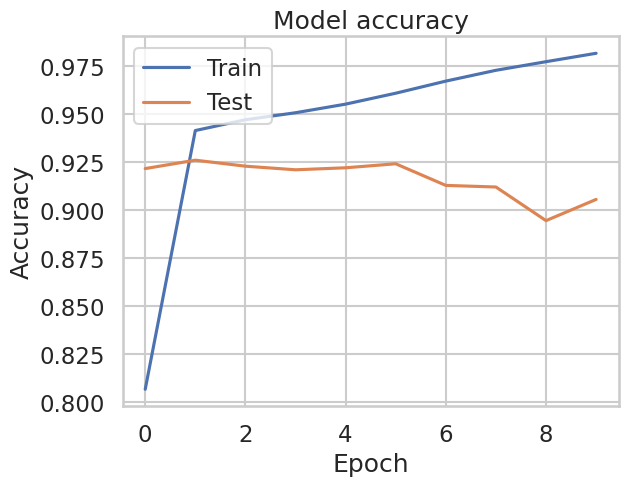

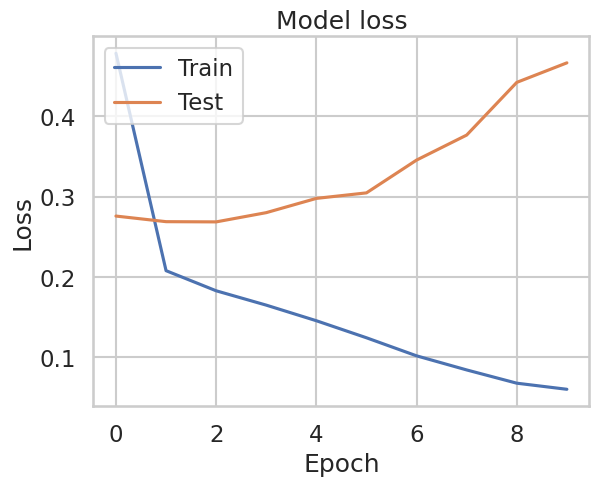

In [ ]:
# plot the graphs for accuracy
plt.plot(bilstm_history.history['accuracy'])
plt.plot(bilstm_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# plot the graphs for loss
plt.plot(bilstm_history.history['loss'])
plt.plot(bilstm_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

# Tokenize the tweets
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(dataset['clean_tweet'].values)
X = tokenizer.texts_to_sequences(dataset['clean_tweet'].values)
X = pad_sequences(X)

# Convert the sentiment labels to one-hot encoded vectors
Y = pd.get_dummies(dataset['sentiment']).values

# Define the model architecture
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128
filter_size = 64
kernel_size = 3

cnn_model = Sequential()
cnn_model.add(Embedding(vocab_size, embedding_dim, input_length=X.shape[1]))
cnn_model.add(Conv1D(filter_size, kernel_size, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(3, activation='softmax'))

# Compile the model
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
cnn_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 33, 128)           2713984   
                                                                 
 conv1d (Conv1D)             (None, 31, 64)            24640     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 2,738,819
Trainable params: 2,738,819
Non-trainable params: 0
_________________________________________________________________


In [ ]:

# Train the model
batch_size = 32
epochs = 10
cnn_history = cnn_model.fit(X, Y, batch_size=batch_size, epochs=epochs, validation_split=0.2)


Epoch 1/10
600/600 [==============================] - 27s 43ms/step - loss: 0.4476 - accuracy: 0.8471 - val_loss: 0.2750 - val_accuracy: 0.9246
Epoch 2/10
600/600 [==============================] - 25s 42ms/step - loss: 0.2118 - accuracy: 0.9401 - val_loss: 0.2600 - val_accuracy: 0.9256
Epoch 3/10
600/600 [==============================] - 26s 43ms/step - loss: 0.1596 - accuracy: 0.9520 - val_loss: 0.2699 - val_accuracy: 0.9240
Epoch 4/10
600/600 [==============================] - 26s 44ms/step - loss: 0.1141 - accuracy: 0.9658 - val_loss: 0.2972 - val_accuracy: 0.9212
Epoch 5/10
600/600 [==============================] - 26s 43ms/step - loss: 0.0729 - accuracy: 0.9786 - val_loss: 0.3420 - val_accuracy: 0.9175
Epoch 6/10
600/600 [==============================] - 26s 43ms/step - loss: 0.0464 - accuracy: 0.9878 - val_loss: 0.3853 - val_accuracy: 0.9077
Epoch 7/10
600/600 [==============================] - 26s 43ms/step - loss: 0.0280 - accuracy: 0.9929 - val_loss: 0.4339 - val_accuracy:

In [ ]:
# Evaluate model
loss, accuracy = cnn_model.evaluate(X_test, Y_test, batch_size=32)
print('Loss:', loss)
print('Accuracy:', accuracy)

188/188 [==============================] - 1s 3ms/step - loss: 0.1124 - accuracy: 0.9800
Loss: 0.1123552992939949
Accuracy: 0.9800000190734863


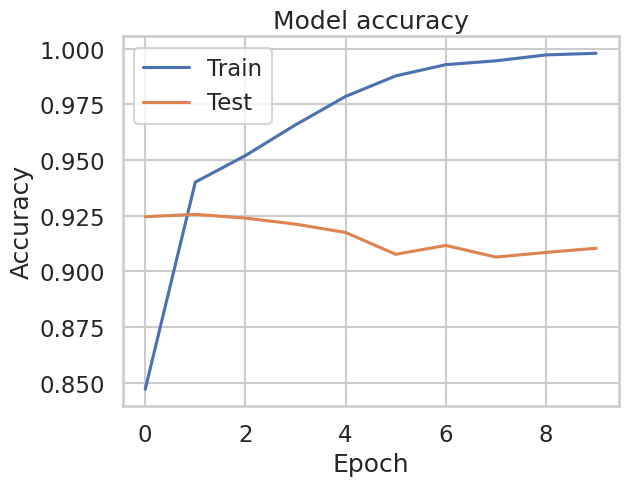

In [ ]:
# plot the graphs for accuracy
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


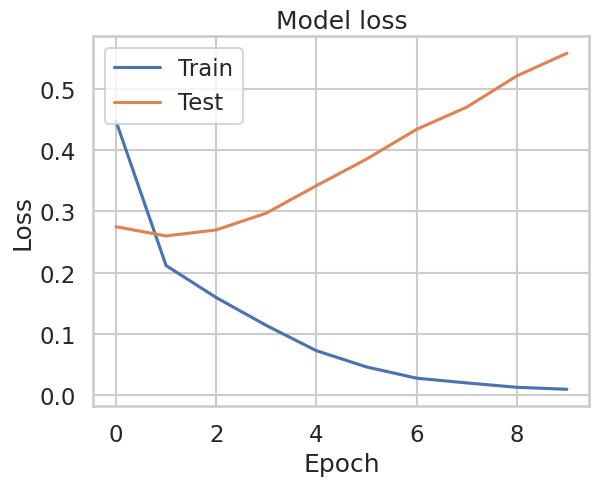

In [ ]:

# plot the graphs for loss
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### https://www.analyticsvidhya.com/blog/2021/12/sentiment-analysis-on-tweets-with-lstm-for-beginners/
#### https://medium.com/@deephavendatalabs/real-time-sentiment-analysis-using-an-lstm-network-in-tensorflow-178857e87b52
